Experiment E1-15b:
- binary classification
- dataset train full 8k, val 2k
- BATCH_SIZE = 20
- IMAGE_SIZE = 384
- EPOCHS = 20
- criterion = nn.BCEWithLogitsLoss()
- optimizer = Adam
- lr=1e-5
- augmentation

model:
- self.base_model(x)
- unfreeze 4 layers
- self.globalavg(x) # (2,2)
- self.flatten(x)
- self.fc(x) # (5120,512)->Relu->Dropout(0.5)->(512,1)

In [3]:
import numpy as np
import os
import sys
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, models
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from PIL import Image

In [4]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils


In [5]:
# override config for experiment
EXP_CODE = "E1-15b"
SAVE_FILENAME = f"stage1-{EXP_CODE}-metrics"
MODEL_SAVE_PATH = f"stage1-{EXP_CODE}-model.pth"

config.EPOCHS = 20
config.LEARNING_RATE = 1e-5
config.IMAGE_SIZE = 384

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

common_utils.set_seed(config.SEED)


In [7]:
df = pd.read_csv(config.TRAIN_CSV)

In [8]:
# split data into train, val, test 70/15/15
# for fast training, use only 3500 and 1500 samples for train and val

train_df, val_df, test_df, _, _ = data_utils.split_data(df, config.SEED)

In [9]:
# create transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [10]:
# create datasets
train_dataset = data_utils.SteelDataset(df=train_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=train_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                    )
val_dataset = data_utils.SteelDataset(df=val_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=test_val_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                   )


In [11]:
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True,
                          num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                          )

val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                         )


In [12]:
# create model
class SteelModel(nn.Module):
    def __init__(self):
        super(SteelModel, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        for p in self.base_model[-4:].parameters():
            p.requires_grad = True

        # Remove original classifier
        #self.base_model.classifier = nn.Identity()

        self.globalavg = nn.AdaptiveAvgPool2d((2, 2))

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(1280 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        #print(x.shape)
        x = self.globalavg(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x 

In [11]:
model = SteelModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [12]:
%%time

arr_train_acc = []
arr_train_loss = []
arr_train_precision = []
arr_train_recall = []
arr_train_f1 = []
arr_train_rocauc = []
arr_train_conf_matrix = []

arr_val_acc = []
arr_val_loss = []
arr_val_precision = []
arr_val_recall = []
arr_val_f1 = []
arr_val_rocauc = []
arr_val_conf_matrix = []

idx = 0
for epoch in range(config.EPOCHS):
    train_loss, train_all_labels, train_all_preds, train_all_probs = train_utils.train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_all_labels, val_all_preds, val_all_probs = train_utils.validate_one_epoch(model, val_loader, criterion, device)

    # train metrics
    train_accuracy = (train_all_preds == train_all_labels).mean()
    train_precision = precision_score(train_all_labels, train_all_preds)
    train_recall = recall_score(train_all_labels, train_all_preds)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    train_rocauc = roc_auc_score(train_all_labels, train_all_probs)
    train_conf_matrix = confusion_matrix(train_all_labels, train_all_preds)
    train_tn, train_fp, train_fn, train_tp = train_conf_matrix.ravel()
    
    arr_train_loss.append(train_loss)
    arr_train_acc.append(train_accuracy)
    arr_train_precision.append(train_precision)
    arr_train_recall.append(train_recall)
    arr_train_f1.append(train_f1)
    arr_train_rocauc.append(train_rocauc)
    arr_train_conf_matrix.append({'tn': train_tn, 'fp': train_fp, 'fn': train_fn, 'tp': train_tp})

    # val metrics
    val_accuracy = (val_all_preds == val_all_labels).mean()
    val_precision = precision_score(val_all_labels, val_all_preds)
    val_recall = recall_score(val_all_labels, val_all_preds)
    val_f1 = f1_score(val_all_labels, val_all_preds)
    val_rocauc = roc_auc_score(val_all_labels, val_all_probs)
    val_conf_matrix = confusion_matrix(val_all_labels, val_all_preds)
    val_tn, val_fp, val_fn, val_tp = val_conf_matrix.ravel()

    arr_val_loss.append(val_loss)
    arr_val_acc.append(val_accuracy)
    arr_val_precision.append(val_precision)
    arr_val_recall.append(val_recall)
    arr_val_f1.append(val_f1)
    arr_val_rocauc.append(val_rocauc)
    arr_val_conf_matrix.append({'tn': val_tn, 'fp': val_fp, 'fn': val_fn, 'tp': val_tp})

    print(idx+1)
    print(f"Epoch {epoch+1}/{config.EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_rocauc:.4f}")
    print(f"  Train Confusion Matrix: TN={train_tn}, FP={train_fp}, FN={train_fn}, TP={train_tp}")
    print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_rocauc:.4f}")
    print(f"  Val Confusion Matrix: TN={val_tn}, FP={val_fp}, FN={val_fn}, TP={val_tp}")

    idx += 1
    #break


1
Epoch 1/20
  Train Loss: 0.4859 | Train Acc: 0.7618
  Val Loss  : 0.2994 | Val Acc: 0.8677
  Train Precision: 0.7482 | Recall: 0.8496 | F1: 0.7957 | ROC AUC: 0.8495
  Train Confusion Matrix: TN=2711, FP=1420, FN=747, TP=4219
  Val Precision: 0.8561 | Recall: 0.9108 | F1: 0.8826 | ROC AUC: 0.9512
  Val Confusion Matrix: TN=722, FP=163, FN=95, TP=970
2
Epoch 2/20
  Train Loss: 0.3161 | Train Acc: 0.8619
  Val Loss  : 0.2322 | Val Acc: 0.9000
  Train Precision: 0.8681 | Recall: 0.8810 | F1: 0.8745 | ROC AUC: 0.9384
  Train Confusion Matrix: TN=3466, FP=665, FN=591, TP=4375
  Val Precision: 0.8933 | Recall: 0.9277 | F1: 0.9102 | ROC AUC: 0.9680
  Val Confusion Matrix: TN=767, FP=118, FN=77, TP=988
3
Epoch 3/20
  Train Loss: 0.2755 | Train Acc: 0.8809
  Val Loss  : 0.2078 | Val Acc: 0.9118
  Train Precision: 0.8850 | Recall: 0.8987 | F1: 0.8918 | ROC AUC: 0.9534
  Train Confusion Matrix: TN=3551, FP=580, FN=503, TP=4463
  Val Precision: 0.9169 | Recall: 0.9221 | F1: 0.9195 | ROC AUC: 0.97

In [13]:
df_metrics = train_utils.build_metric_df(
    arr_train_loss, arr_train_acc, arr_train_precision, arr_train_recall, 
    arr_train_f1, arr_train_rocauc, arr_train_conf_matrix,
    arr_val_loss, arr_val_acc, arr_val_precision, arr_val_recall, 
    arr_val_f1, arr_val_rocauc, arr_val_conf_matrix
)


In [14]:
df_metrics

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_conf_matrix,val_loss,val_acc,val_precision,...,val_rocauc,val_conf_matrix,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
0,0.485916,0.761790,0.748182,0.849577,0.795662,0.849533,"{'tn': 2711, 'fp': 1420, 'fn': 747, 'tp': 4219}",0.299418,0.867692,0.856134,...,0.951236,"{'tn': 722, 'fp': 163, 'fn': 95, 'tp': 970}",2711,1420,747,4219,722,163,95,970
1,0.316073,0.861933,0.868056,0.880991,0.874475,0.938427,"{'tn': 3466, 'fp': 665, 'fn': 591, 'tp': 4375}",0.232226,0.900000,0.893309,...,0.968002,"{'tn': 767, 'fp': 118, 'fn': 77, 'tp': 988}",3466,665,591,4375,767,118,77,988
2,0.275476,0.880950,0.884989,0.898711,0.891797,0.953364,"{'tn': 3551, 'fp': 580, 'fn': 503, 'tp': 4463}",0.207797,0.911795,0.916900,...,0.973560,"{'tn': 796, 'fp': 89, 'fn': 83, 'tp': 982}",3551,580,503,4463,796,89,83,982
3,0.253621,0.891173,0.896016,0.905759,0.900861,0.960347,"{'tn': 3609, 'fp': 522, 'fn': 468, 'tp': 4498}",0.193765,0.928205,0.927845,...,0.976981,"{'tn': 807, 'fp': 78, 'fn': 62, 'tp': 1003}",3609,522,468,4498,807,78,62,1003
4,0.233451,0.901506,0.907326,0.912807,0.910058,0.966437,"{'tn': 3668, 'fp': 463, 'fn': 433, 'tp': 4533}",0.190882,0.927692,0.956522,...,0.978860,"{'tn': 841, 'fp': 44, 'fn': 97, 'tp': 968}",3668,463,433,4533,841,44,97,968
5,0.221479,0.909421,0.913704,0.921063,0.917369,0.969748,"{'tn': 3699, 'fp': 432, 'fn': 392, 'tp': 4574}",0.178977,0.935897,0.955426,...,0.980665,"{'tn': 839, 'fp': 46, 'fn': 79, 'tp': 986}",3699,432,392,4574,839,46,79,986
6,0.212853,0.911070,0.916450,0.921063,0.918751,0.971984,"{'tn': 3714, 'fp': 417, 'fn': 392, 'tp': 4574}",0.165418,0.933846,0.934944,...,0.983082,"{'tn': 815, 'fp': 70, 'fn': 59, 'tp': 1006}",3714,417,392,4574,815,70,59,1006
7,0.199257,0.918984,0.923323,0.928715,0.926011,0.975494,"{'tn': 3748, 'fp': 383, 'fn': 354, 'tp': 4612}",0.160462,0.940000,0.935662,...,0.983938,"{'tn': 815, 'fp': 70, 'fn': 47, 'tp': 1018}",3748,383,354,4612,815,70,47,1018
8,0.190931,0.918984,0.923832,0.928111,0.925967,0.977392,"{'tn': 3751, 'fp': 380, 'fn': 357, 'tp': 4609}",0.158438,0.935385,0.930339,...,0.984249,"{'tn': 809, 'fp': 76, 'fn': 50, 'tp': 1015}",3751,380,357,4609,809,76,50,1015
9,0.189376,0.923381,0.925793,0.934555,0.930153,0.977854,"{'tn': 3759, 'fp': 372, 'fn': 325, 'tp': 4641}",0.155541,0.944615,0.964113,...,0.985218,"{'tn': 848, 'fp': 37, 'fn': 71, 'tp': 994}",3759,372,325,4641,848,37,71,994


In [15]:
print('Val Metrics:')
print(df_metrics[config.VAL_METRICS])
print('')
print('Val Confusion Matrix:')
print(df_metrics[config.VAL_CF])

Val Metrics:
    val_loss   val_acc  val_precision  val_recall    val_f1  val_rocauc
0   0.299418  0.867692       0.856134    0.910798  0.882621    0.951236
1   0.232226  0.900000       0.893309    0.927700  0.910180    0.968002
2   0.207797  0.911795       0.916900    0.922066  0.919476    0.973560
3   0.193765  0.928205       0.927845    0.941784  0.934762    0.976981
4   0.190882  0.927692       0.956522    0.908920  0.932114    0.978860
5   0.178977  0.935897       0.955426    0.925822  0.940391    0.980665
6   0.165418  0.933846       0.934944    0.944601  0.939748    0.983082
7   0.160462  0.940000       0.935662    0.955869  0.945657    0.983938
8   0.158438  0.935385       0.930339    0.953052  0.941558    0.984249
9   0.155541  0.944615       0.964113    0.933333  0.948473    0.985218
10  0.155333  0.942051       0.963035    0.929577  0.946011    0.985596
11  0.155786  0.943077       0.968566    0.925822  0.946711    0.986216
12  0.142051  0.948718       0.954760    0.951174  

In [16]:
df_metrics.describe()

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,val_loss,val_acc,val_precision,val_recall,val_f1,val_rocauc,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.206003,0.913867,0.916775,0.927688,0.922058,0.969560,0.169106,0.934641,0.940700,0.940282,0.940296,0.981972,3706.550000,424.450000,359.100000,4606.900000,821.150000,63.850000,63.600000,1001.400000
std,0.081877,0.042787,0.045620,0.027197,0.036562,0.031082,0.040283,0.020475,0.027117,0.016620,0.017927,0.009079,260.620207,260.620207,135.057843,135.057843,31.377624,31.377624,17.700431,17.700431
min,0.139292,0.761790,0.748182,0.849577,0.795662,0.849533,0.136369,0.867692,0.856134,0.908920,0.882621,0.951236,2711.000000,235.000000,224.000000,4219.000000,722.000000,32.000000,37.000000,968.000000
25%,0.152979,0.907442,0.912109,0.918999,0.915541,0.968920,0.141454,0.932436,0.933793,0.927230,0.938501,0.980214,3691.250000,284.750000,260.750000,4563.750000,813.500000,45.500000,48.750000,987.500000
50%,0.184460,0.925745,0.929102,0.935360,0.932219,0.978914,0.155663,0.942564,0.951004,0.943192,0.946361,0.985407,3776.500000,354.500000,321.000000,4645.000000,832.500000,52.500000,60.500000,1004.500000
75%,0.224472,0.938634,0.942797,0.947493,0.943839,0.985445,0.181953,0.946795,0.955700,0.954225,0.951140,0.987391,3846.250000,439.750000,402.250000,4705.250000,839.500000,71.500000,77.500000,1016.250000
max,0.485916,0.949544,0.952783,0.954893,0.953837,0.987538,0.299418,0.950256,0.968566,0.965258,0.954652,0.988527,3896.000000,1420.000000,747.000000,4742.000000,853.000000,163.000000,97.000000,1028.000000


In [17]:
print(df_metrics.describe())

       train_loss  train_acc  train_precision  train_recall   train_f1  \
count   20.000000  20.000000        20.000000     20.000000  20.000000   
mean     0.206003   0.913867         0.916775      0.927688   0.922058   
std      0.081877   0.042787         0.045620      0.027197   0.036562   
min      0.139292   0.761790         0.748182      0.849577   0.795662   
25%      0.152979   0.907442         0.912109      0.918999   0.915541   
50%      0.184460   0.925745         0.929102      0.935360   0.932219   
75%      0.224472   0.938634         0.942797      0.947493   0.943839   
max      0.485916   0.949544         0.952783      0.954893   0.953837   

       train_rocauc   val_loss    val_acc  val_precision  val_recall  \
count     20.000000  20.000000  20.000000      20.000000   20.000000   
mean       0.969560   0.169106   0.934641       0.940700    0.940282   
std        0.031082   0.040283   0.020475       0.027117    0.016620   
min        0.849533   0.136369   0.867692    

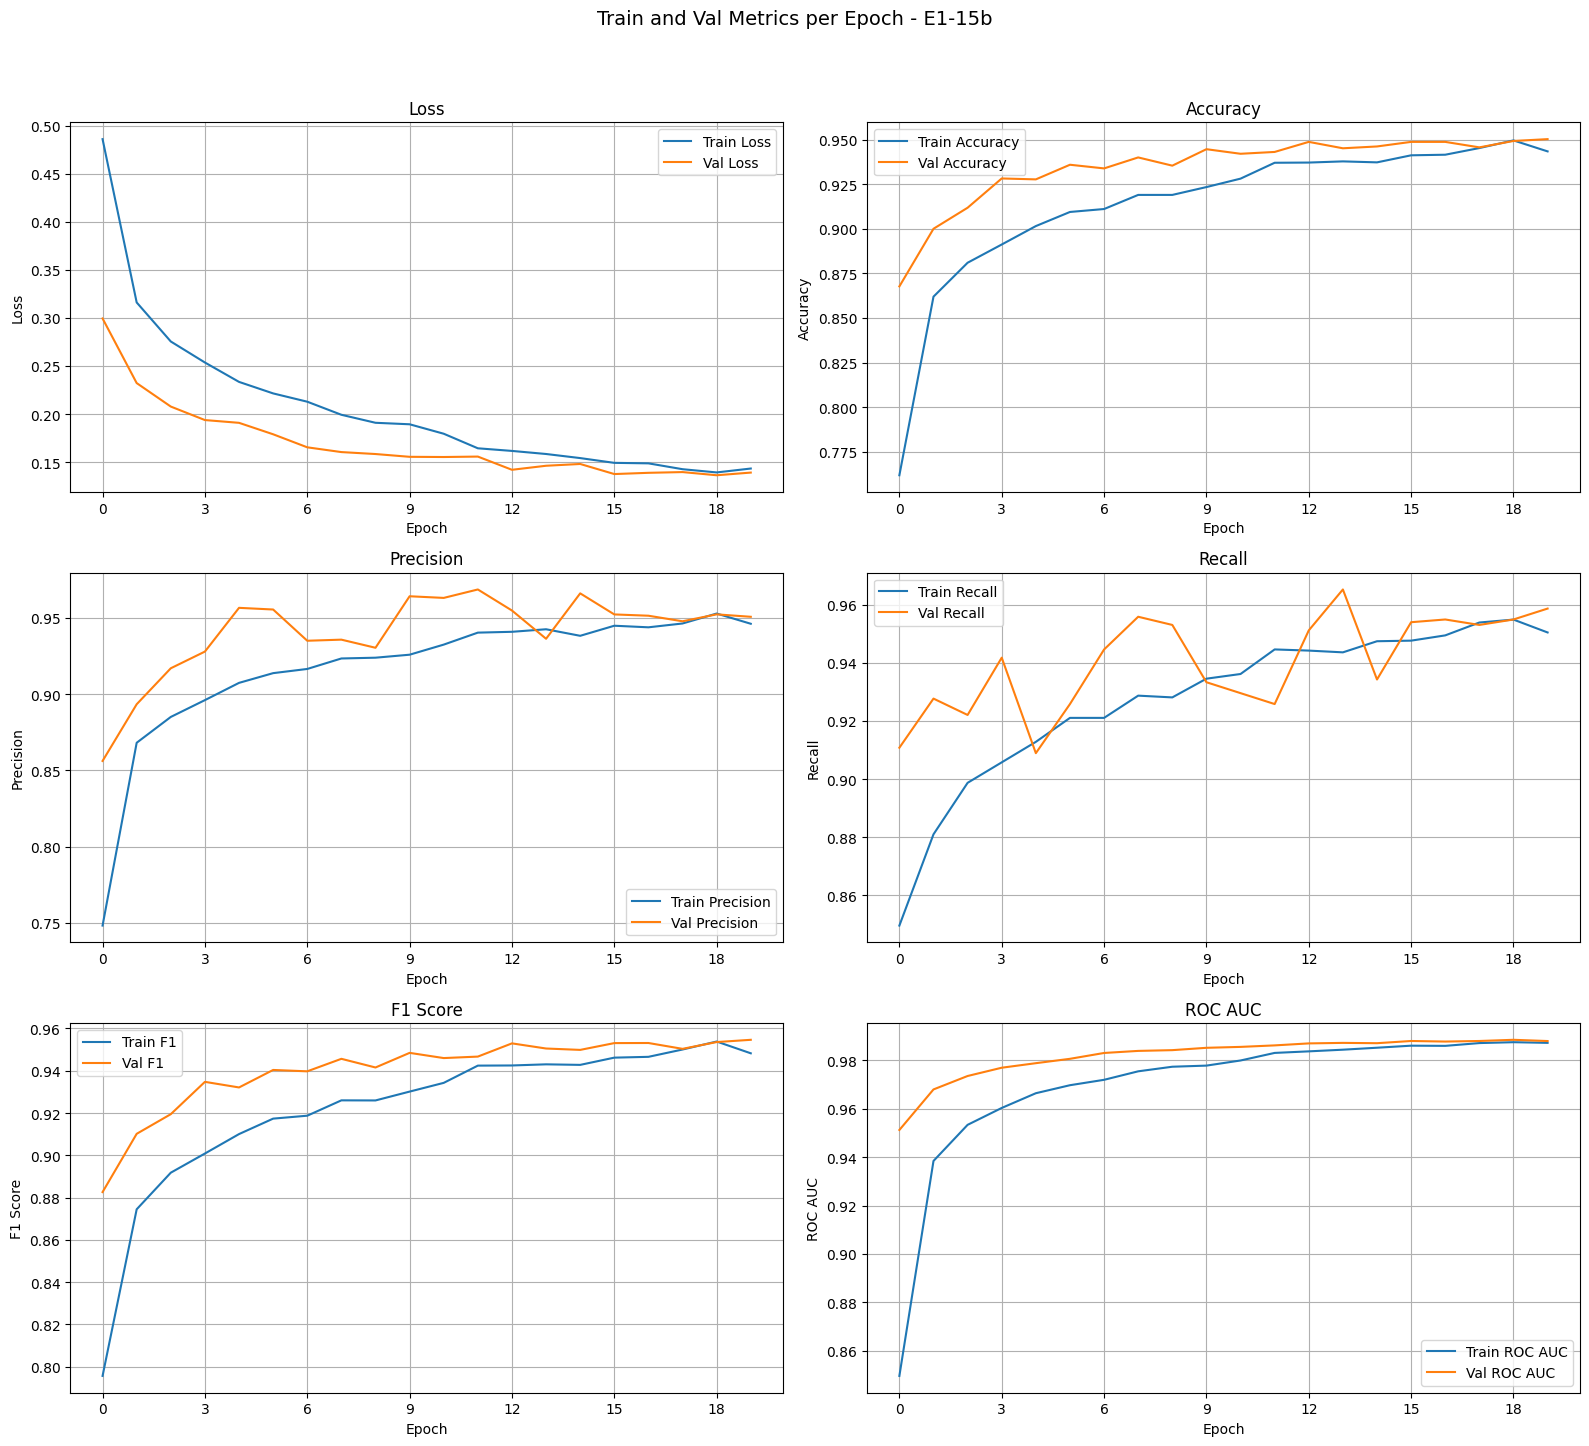

In [18]:
plot_utils.plot_train_val_metrics(df_metrics, exp_code=EXP_CODE, save_path=SAVE_FILENAME+".png")

In [19]:
df_train_conf_matrix = df_metrics['train_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
df_val_conf_matrix = df_metrics['val_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
#df_metrics[['val_tn', 'val_fp', 'val_fn', 'val_tp']]
df_train_conf_matrix.columns = ['train_tn', 'train_fp', 'train_fn', 'train_tp']
df_val_conf_matrix.columns = ['val_tn', 'val_fp', 'val_fn', 'val_tp']



In [20]:
df_train_conf_matrix.describe()

,train_tn,train_fp,train_fn,train_tp
count,20.000000,20.000000,20.000000,20.000000
mean,3706.550000,424.450000,359.100000,4606.900000
std,260.620207,260.620207,135.057843,135.057843
min,2711.000000,235.000000,224.000000,4219.000000
25%,3691.250000,284.750000,260.750000,4563.750000
50%,3776.500000,354.500000,321.000000,4645.000000
75%,3846.250000,439.750000,402.250000,4705.250000
max,3896.000000,1420.000000,747.000000,4742.000000


In [21]:
df_val_conf_matrix.describe()

,val_tn,val_fp,val_fn,val_tp
count,20.000000,20.000000,20.000000,20.000000
mean,821.150000,63.850000,63.600000,1001.400000
std,31.377624,31.377624,17.700431,17.700431
min,722.000000,32.000000,37.000000,968.000000
25%,813.500000,45.500000,48.750000,987.500000
50%,832.500000,52.500000,60.500000,1004.500000
75%,839.500000,71.500000,77.500000,1016.250000
max,853.000000,163.000000,97.000000,1028.000000


In [22]:
df_metrics.to_csv(SAVE_FILENAME+".csv", index=False)

In [23]:
# save model weights

torch.save(model.state_dict(), MODEL_SAVE_PATH)


# Find best threshold

In [13]:
# load model weights
model_loaded = SteelModel()
model_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))
model_loaded = model_loaded.to(device)

In [14]:
%%time

thresholds = np.arange(0.0, 1.01, 0.01)
criterion = nn.BCEWithLogitsLoss()

arr_thresholds = []
for idx, threshold in enumerate(thresholds):
    th_val_loss, th_val_all_labels, th_val_all_preds, th_val_all_probs = train_utils.validate_one_epoch(
        model_loaded, val_loader, criterion, device, threshold
    )
    th_val_pred_labels = (th_val_all_probs >= threshold).astype(int)
    th_val_accuracy = accuracy_score(th_val_all_labels, th_val_pred_labels)
    th_val_precision = precision_score(th_val_all_labels, th_val_pred_labels)
    th_val_recall = recall_score(th_val_all_labels, th_val_pred_labels)
    th_val_f1 = f1_score(th_val_all_labels, th_val_pred_labels)
    th_val_rocauc = roc_auc_score(th_val_all_labels, th_val_all_probs)
    th_val_conf_matrix = confusion_matrix(th_val_all_labels, th_val_pred_labels)
    th_val_tn, th_val_fp, th_val_fn, th_val_tp = th_val_conf_matrix.ravel()

    arr_thresholds.append({
        'threshold': threshold,
        'accuracy': th_val_accuracy,
        'precision': th_val_precision,
        'recall': th_val_recall,
        'f1': th_val_f1,
        'rocauc': th_val_rocauc,
        'tn': th_val_tn,
        'fp': th_val_fp,
        'fn': th_val_fn,
        'tp': th_val_tp,
    })

    if idx % 10 == 0:
        print(idx)
    
df_thresholds = pd.DataFrame(arr_thresholds)

0
10
20
30
40
50
60
70
80
90
100
CPU times: user 7min 32s, sys: 2min 32s, total: 10min 4s
Wall time: 8min 24s


/home/bigberi/venv/ml2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [15]:
df_thresholds.to_csv(f"stage1-{EXP_CODE}-val-threshold-metrics.csv", index=False)

In [16]:
df_thresholds

,threshold,accuracy,precision,recall,f1,rocauc,tn,fp,fn,tp
0,0.00,0.546154,0.546154,1.000000,0.706468,0.988015,0,885,0,1065
1,0.01,0.824103,0.757123,0.998122,0.861077,0.988015,544,341,2,1063
2,0.02,0.863077,0.800452,0.998122,0.888425,0.988015,620,265,2,1063
3,0.03,0.879487,0.821705,0.995305,0.900212,0.988015,655,230,5,1060
4,0.04,0.889744,0.836767,0.991549,0.907606,0.988015,679,206,9,1056
...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.876410,0.986998,0.784038,0.873888,0.988015,874,11,230,835
97,0.97,0.865128,0.991422,0.759624,0.860181,0.988015,878,7,256,809
98,0.98,0.835385,0.994681,0.702347,0.823335,0.988015,881,4,317,748
99,0.99,0.790256,0.996970,0.617840,0.762899,0.988015,883,2,407,658


In [17]:
index_best_threshold = np.argmax(df_thresholds['f1'])
best_threshold = df_thresholds.iloc[index_best_threshold]['threshold']
print(index_best_threshold)

51


In [18]:

print('Best threshold:', best_threshold)
print('Best f1 score:', max(df_thresholds['f1']))
print('Best precision:', df_thresholds.loc[index_best_threshold]['precision'] )
print('Best recall:', df_thresholds.loc[index_best_threshold]['recall'] )

Best threshold: 0.51
Best f1 score: 0.955503512880562
Best precision: 0.9532710280373832
Best recall: 0.9577464788732394


In [19]:
tn, fp, fn, tp = df_thresholds.loc[index_best_threshold]['tn'], df_thresholds.loc[index_best_threshold]['fp'], df_thresholds.loc[index_best_threshold]['fn'], df_thresholds.loc[index_best_threshold]['tp']
print("Confusion Matrix:\n", f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

Confusion Matrix:
 TN=835.0, FP=50.0, FN=45.0, TP=1020.0


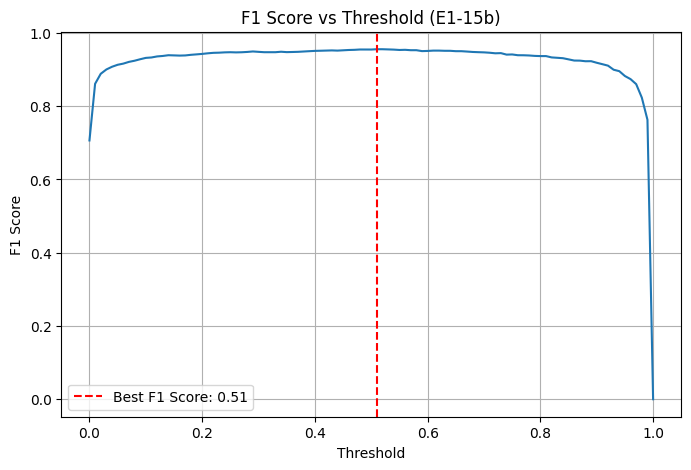

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(df_thresholds['threshold'], df_thresholds['f1'])
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
best_f1_threshold = df_thresholds.loc[df_thresholds['f1'].idxmax(), 'threshold']
plt.axvline(best_f1_threshold, color='red', linestyle='--', label=f'Best F1 Score: {best_f1_threshold:.2f}')
plt.legend()
plt.title(f'F1 Score vs Threshold ({EXP_CODE})')
plt.grid(True)
plt.show()

In [21]:
# calculate precision and recall crossing
array_precision = df_thresholds['precision'].values
array_recall = df_thresholds['recall'].values

# threshold with precision cross recall
cross_threshold = 0.0
for i in range(len(thresholds)):
    if array_precision[i] >= array_recall[i]:
        cross_threshold = thresholds[i]
        print(f'Threshold Cross: {cross_threshold:.2f}, Precision: {array_precision[i]:.3f}, Recall: {array_recall[i]:.3f}')
        break


Threshold Cross: 0.54, Precision: 0.955, Recall: 0.954


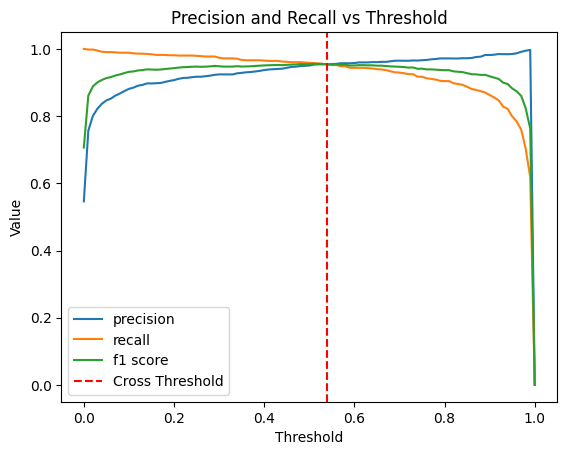

In [22]:
plt.plot(df_thresholds['threshold'], df_thresholds['precision'], label='precision')
plt.plot(df_thresholds['threshold'], df_thresholds['recall'], label='recall')  
plt.plot(df_thresholds['threshold'], df_thresholds['f1'], label='f1 score')
plt.axvline(x=cross_threshold, color='r', linestyle='--', label='Cross Threshold')
plt.title('Precision and Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()
plt.show()